<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>

Figure 1.1.a. Jupyter environment + Python notebooks

# Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

## Step 1.1: Configure the environment

In [1]:
from datetime import datetime
from shapely.geometry import Polygon
from shapely import box
from pyproj import CRS 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
import joblib
from ipyleaflet import basemaps
import pystac_client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import planetary_computer
from odc.stac import load
from pystac.client import Client
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from matplotlib import colors
from utils import load_data, scale, calculate_band_indices, apply_mask, mask_water, mask_urban, all_masks, do_prediction

In [2]:
# Reload scripts and imports
%load_ext autoreload
%autoreload 2

In [3]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"

# Enter your site name
site = "tongatapu"

# Date
date = datetime.now()

# Make a clean version string
version = f"{initials}-{site}-{date.strftime('%d%m%Y')}"
print(version)

nm-tongatapu-11122025


## Step 1.2: Configure STAC access and search parameters

In [4]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [5]:
## Use training data bounds

training = gpd.read_file(f"training-data/nm-{site}.geojson")
training = training.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = training.total_bounds

bbox = [min_lon, min_lat, max_lon, max_lat]

In [6]:
training

fid    id Descriptio LULC_code     LULC_class  Long   Lat  \
0    None  None       None         7  Surface_water  None  None   
1    None  None       None         7  Surface_water  None  None   
2    None  None       None         7  Surface_water  None  None   
3    None  None       None         7  Surface_water  None  None   
4    None  None       None         7  Surface_water  None  None   
..    ...   ...        ...       ...            ...   ...   ...   
675  None  None       None         7  Surface_water  None  None   
676  None  None       None         7  Surface_water  None  None   
677  None  None       None         7  Surface_water  None  None   
678  None  None       None         7  Surface_water  None  None   
679  None  None       None         7  Surface_water  None  None   

                         geometry  
0    POINT (-175.32648 -21.05595)  
1    POINT (-175.36156 -21.09345)  
2    POINT (-175.12939 -21.27945)  
3     POINT (-175.02447 -21.1477)  
4    POINT (-175.31365 -21.16867)  
..                            ...  
675  POINT (-175.31826 -21.11551)  
676  POINT (-175.17051 -21.19554)  
677  POINT (-175.17143 -21.18371)  
678   POINT (-175.13839 -21.1745)  
679   POINT (-175.1401 -21.18946)  

[680 rows x 8 columns]

In [7]:
training.columns.unique()

Index(['fid', 'id', 'Descriptio', 'LULC_code', 'LULC_class', 'Long', 'Lat',
       'geometry'],
      dtype='object')

In [8]:
# bbox = [178.410921, -18.188382, 178.46952, -18.14731]

In [9]:
datetime = "2023"

items = client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items in for {datetime}")

Found 1 items in for 2023


In [10]:
measurements = ["nir", "red", "blue", "green", "emad", "smad", "bcmad", "green", "nir08", "nir09", "swir16", "swir22", "coastal", "rededge1", "rededge2", "rededge3"]
data = load_data(
    items,
    measurements,
    bbox,
)
    
# Now you can use the 'data' variable
print(data)

<xarray.Dataset> Size: 359MB
Dimensions:      (y: 2654, x: 3753, time: 1)
Coordinates:
  * y            (y) float64 21kB -2.383e+06 -2.383e+06 ... -2.41e+06 -2.41e+06
  * x            (x) float64 30kB 3.856e+06 3.856e+06 ... 3.893e+06 3.893e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2023-01-01
Data variables: (12/15)
    nir          (time, y, x) uint16 20MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 20MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 20MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 20MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    emad         (time, y, x) float32 40MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    smad         (time, y, x) float32 40MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 20MB

In [11]:
# dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
# configure_s3_access(cloud_defaults=True, requester_pays=True)

In [12]:
scaled = scale(data)
scaled = scaled.compute().squeeze()

In [13]:
scaled = calculate_band_indices(scaled)
# Dataset = scaled
# Dataset.odc.explore(vmin = 0, vmax = 0.3, bands = ["red", "green", "blue"], crs="EPSG:3832", name=site)

In [14]:
# All masks
masked_scaled, mask = all_masks(scaled, return_mask = True)
masked_scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

/srv/conda/envs/notebook/lib/python3.11/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


In [15]:
masked_scaled

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 2654, x: 3753)
Coordinates:
  * y            (y) float64 21kB -2.383e+06 -2.383e+06 ... -2.41e+06 -2.41e+06
  * x            (x) float64 30kB 3.856e+06 3.856e+06 ... 3.893e+06 3.893e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2023-01-01
Data variables: (12/25)
    nir          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    green        (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    emad         (y, x) float32 40MB nan nan nan nan nan ... nan nan nan nan nan
    smad         (y, x) float32 40MB nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    evi          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    savi         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    ndwi         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    mci          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    ndci         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    nbi          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan

In [16]:
# combined_ds = masked_scaled.drop_vars("count")
combined_da = masked_scaled.to_dataarray()
combined_da = combined_da.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays_2d = combined_da.stack(new_dim=("y", "x")) 
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')
stacked_arrays_2d.shape

(25, 9960462)

In [17]:
# Replace any infinities with NaN
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("inf"))
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays_2d.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)

reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

### Model training

In [18]:
reordered_data_array

<xarray.DataArray (new_dim: 9960462, variable: 25)> Size: 2GB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2023-01-01
  * variable     (variable) object 200B 'nir' 'red' 'blue' ... 'ndci' 'nbi'
  * new_dim      (new_dim) object 80MB MultiIndex
  * y            (new_dim) float64 80MB -2.383e+06 -2.383e+06 ... -2.41e+06
  * x            (new_dim) float64 80MB 3.856e+06 3.856e+06 ... 3.893e+06

In [19]:
masked_scaled

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 2654, x: 3753)
Coordinates:
  * y            (y) float64 21kB -2.383e+06 -2.383e+06 ... -2.41e+06 -2.41e+06
  * x            (x) float64 30kB 3.856e+06 3.856e+06 ... 3.893e+06 3.893e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2023-01-01
Data variables: (12/25)
    nir          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    blue         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    green        (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    emad         (y, x) float32 40MB nan nan nan nan nan ... nan nan nan nan nan
    smad         (y, x) float32 40MB nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    evi          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    savi         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    ndwi         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    mci          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    ndci         (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan
    nbi          (y, x) float64 80MB nan nan nan nan nan ... nan nan nan nan nan

In [20]:
model = joblib.load("models/nm-tongatapu-09122025-test.model")

In [21]:
# Predict the classes
predicted = model.predict(reordered_data_array)

In [22]:
# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(masked_scaled.y), len(masked_scaled.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": masked_scaled.y, "x": masked_scaled.x}, dims=["y", "x"]
)

In [23]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

float32


In [24]:
masked_scaled = masked_scaled.compute()

In [25]:
# masked_scaled = masked_scaled.drop_vars("count")

predicted = do_prediction(masked_scaled, model)
predicted
# predicted.odc.explore(cmap=c_map, tiles=basemaps.Esri.WorldImagery)

<xarray.DataArray (y: 2654, x: 3753)> Size: 40MB
array([[7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       ...,
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.]], dtype=float32)
Coordinates:
  * y        (y) float64 21kB -2.383e+06 -2.383e+06 ... -2.41e+06 -2.41e+06
  * x        (x) float64 30kB 3.856e+06 3.856e+06 ... 3.893e+06 3.893e+06

In [26]:
print(predicted)

<xarray.DataArray (y: 2654, x: 3753)> Size: 40MB
array([[7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       ...,
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 7., 7., 7.]], dtype=float32)
Coordinates:
  * y        (y) float64 21kB -2.383e+06 -2.383e+06 ... -2.41e+06 -2.41e+06
  * x        (x) float64 30kB 3.856e+06 3.856e+06 ... 3.893e+06 3.893e+06


In [27]:
predicted = predicted.where(mask)
# `prediction` is your predicted class array# `mask` is your boolean mask, where True means masked
nodata_value = 0  # or -9999, or whatever you chooseprediction_with_mask = prediction.copy()
predicted['mask'] = nodata_value

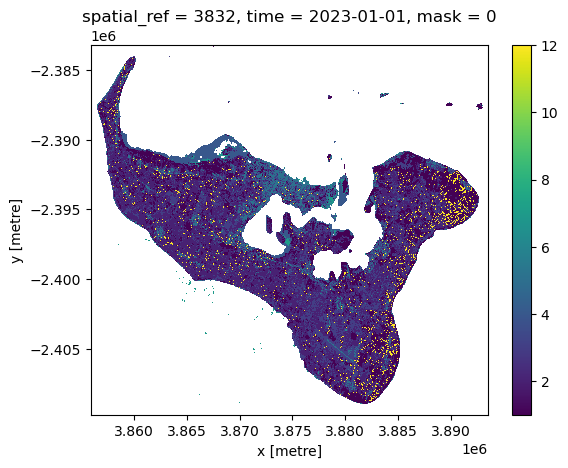

In [28]:
predicted.plot()

In [29]:
# predicted.odc.write_cog("prediction_serua_3b.tif")

In [30]:
from matplotlib import colors

classes = [ 
    [1, 'Forest_land', '#064a00'],
    [2, 'Cropland', '#b67e00' ],
    [3, 'Grassland', '#d7ffa0'],
    [4, 'Wetland', '#73ffd2'],
    [5, 'Settlements', '#bd0007'],
    [6, 'Bare_land','#919191'],
    [7, 'Surface_water','#71a8ff'],
    [8, 'Shallow_ocean','#4a8ffc'],
    [9, 'Seagrass','#fc4aea'],
    [10, 'Coral_reef', '#8f0e82'],
    [11, 'Deep_ocean','#00299f'],
    [12, 'Shrubs', '#759f00'],
]


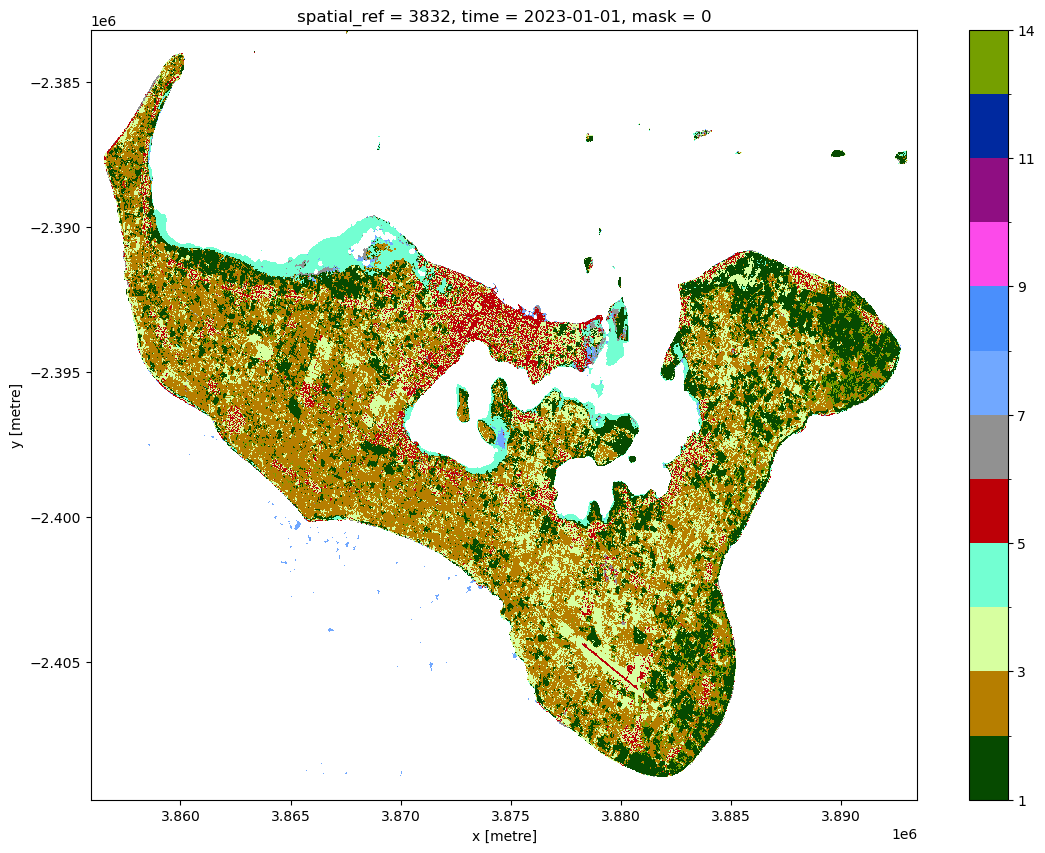

In [31]:
values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted.plot.imshow(cmap=c_map, norm=norm, size=10)

In [32]:
predicted.odc.explore(cmap = c_map)

# scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [33]:
# predicted.odc.write_cog(f"{version}-prediction.tiff")

In [34]:
training

fid    id Descriptio LULC_code     LULC_class  Long   Lat  \
0    None  None       None         7  Surface_water  None  None   
1    None  None       None         7  Surface_water  None  None   
2    None  None       None         7  Surface_water  None  None   
3    None  None       None         7  Surface_water  None  None   
4    None  None       None         7  Surface_water  None  None   
..    ...   ...        ...       ...            ...   ...   ...   
675  None  None       None         7  Surface_water  None  None   
676  None  None       None         7  Surface_water  None  None   
677  None  None       None         7  Surface_water  None  None   
678  None  None       None         7  Surface_water  None  None   
679  None  None       None         7  Surface_water  None  None   

                         geometry  
0    POINT (-175.32648 -21.05595)  
1    POINT (-175.36156 -21.09345)  
2    POINT (-175.12939 -21.27945)  
3     POINT (-175.02447 -21.1477)  
4    POINT (-175.31365 -21.16867)  
..                            ...  
675  POINT (-175.31826 -21.11551)  
676  POINT (-175.17051 -21.19554)  
677  POINT (-175.17143 -21.18371)  
678   POINT (-175.13839 -21.1745)  
679   POINT (-175.1401 -21.18946)  

[680 rows x 8 columns]

In [35]:
df = pd.read_csv("training-data/nm-tongatapu-09122025-training.csv")

In [36]:
df

LULC_code     nir     red    blue   green      emad          smad  \
0            5  0.3070  0.1063  0.0852  0.1147  0.079907  1.330000e-07   
1            3  0.3419  0.0842  0.0633  0.0989  0.156016  6.550000e-07   
2            3  0.2105  0.0710  0.0717  0.0841  0.170746  1.640000e-06   
3            3  0.3322  0.1085  0.0794  0.1169  0.133435  6.230000e-07   
4            3  0.2817  0.1015  0.0749  0.1016  0.130518  6.960000e-07   
..         ...     ...     ...     ...     ...       ...           ...   
569          3  0.4121  0.0907  0.0691  0.1135  0.173982  4.850000e-07   
570          3  0.4047  0.0822  0.0641  0.1079  0.148792  4.860000e-07   
571          1  0.4006  0.0349  0.0336  0.0579  0.132552  1.590000e-07   
572          1  0.3680  0.0374  0.0353  0.0554  0.110063  1.610000e-07   
573          7  0.0696  0.0964  0.1038  0.1231  0.172442  2.020000e-06   

        bcmad   nir08   nir09  ...       cai      ndvi       evi      savi  \
0    0.000005  0.3332  0.3604  ... -0.085350  0.485604  0.506356  0.485604   
1    0.000010  0.3326  0.3506  ... -0.046281  0.604788  0.561482  0.604788   
2    0.000012  0.2695  0.3155  ...  0.156966  0.495560  0.414334  0.495560   
3    0.000008  0.3098  0.1713  ...  0.057007  0.507602  0.520285  0.507602   
4    0.000008  0.2729  0.2862  ...  0.056081  0.470251  0.453554  0.470251   
..        ...     ...     ...  ...       ...       ...       ...       ...   
569  0.000008  0.4341  0.4378  ... -0.019174  0.639220  0.653350  0.639220   
570  0.000007  0.4300  0.4168  ...  0.077034  0.662354  0.655929  0.662354   
571  0.000008  0.4103  0.4384  ...  0.004444  0.839724  0.711782  0.839724   
572  0.000007  0.4022  0.4148  ... -0.020231  0.815491  0.664784  0.815491   
573  0.000021  0.1243  0.1583  ... -0.064070 -0.161446  0.089247 -0.161446   

         ndwi       mci      ndci       nbi        y        x  
0   -0.456011  1.996099  0.182622 -0.125986 -2393675  3876145  
1   -0.551270  2.274784  0.281876 -0.234519 -2404505  3875165  
2   -0.429056  1.585090  0.303238 -0.053027 -2404585  3875195  
3   -0.479403  2.038037  0.200737 -0.115327 -2404405  3875085  
4   -0.469867  1.978230  0.167692 -0.062017 -2404345  3875065  
..        ...       ...       ...       ...      ...      ...  
569 -0.568113  2.270523  0.333578 -0.092090 -2405355  3880255  
570 -0.579009  2.355646  0.352756 -0.105889 -2405235  3880205  
571 -0.747437  4.138430  0.470008 -0.360734 -2405735  3880015  
572 -0.738309  3.845350  0.438017 -0.316637 -2406105  3880525  
573  0.277634  0.610526  0.083650  0.358230 -2392595  3874655  

[574 rows x 28 columns]

In [37]:
len(df)

574

In [38]:
print(df["LULC_code"].value_counts())
# df = training['LULC_code'] != 8

LULC_code
3     138
2     122
5     103
1      75
12     55
6      43
4      30
7       8
Name: count, dtype: int64


## Accuracy Assessment